<a href="https://www.kaggle.com/code/taimour/blend-xgb-lgbm-eda-cmi-internet-usage?scriptVersionId=202330322" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align:center"><span style="background-color:#15a15b;padding:15px;border-radius:40px;">💻 Blend Models XGB, LGBM - CMI Problematic Internet Usage</span></div>


![](https://i.postimg.cc/HL1fFP5X/pexels-ron-lach-9783375.jpg)

# <span style="background-color:#79a5ed;padding:15px;border-radius:40px;">🎒Import Libraries</span>

In [1]:
import numpy as np
import pandas as pd
import polars as pl
from sklearn.base import clone
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
# pd.options.display.max_columns = None

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb

from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

n_splits = 5

# <span style="background-color:#79a5ed;padding:15px;border-radius:40px;">✨Preprocessing</span>

In [2]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


Train Shape : (2736, 155) || Test Shape : (20, 154)


# <span style="background-color:#79a5ed;padding:15px;border-radius:40px;">🔎View Data</span>

In [3]:
train.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,Stat_86,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,...,1.546979,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0
5,3,13,1,0,50.0,1,22.279952,59.5,112.2,NaN,...,1.146284,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0


In [4]:
test.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,Stat_86,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,...,1.546979,4.004276,89.751656,0.0,2633.25,4188.5,8.611000e+13,7.0,3.0,85.0
4,3,18,1,3,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=00115b9f/part-0.parquet')
actigraphy

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.021536,0.022214,-1.02237,0.022853,-88.280762,0.0,53.0,4188.0,56940000000000,4,3,41.0
1,0.022005,0.022187,-1.01974,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,0.02224,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.5,4188.5,56955000000000,4,3,41.0
4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.0,57235000000000,4,3,41.0
…,…,…,…,…,…,…,…,…,…,…,…,…
43325,-0.008333,-0.02362,-1.006901,0.007224,-88.595741,0.0,0.0,3824.0,57580000000000,6,3,85.0
43326,0.04873,-0.076725,-0.953776,0.056839,-85.352219,0.0,0.0,3824.0,57640000000000,6,3,85.0
43327,0.38737,0.793151,-0.402214,0.069961,-24.097908,0.0,0.0,3824.0,57645000000000,6,3,85.0


# <span style="background-color:#79a5ed;padding:15px;border-radius:40px;">📊 Exploratory Data Analysis</span>

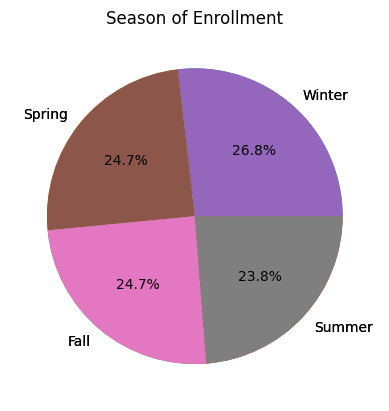

In [6]:
vc = train['Basic_Demos-Enroll_Season'].value_counts()

# Map labels to seasons
season_map = {0: 'Spring', 1: 'Summer', 2: 'Fall', 3: 'Winter'}

# Create labels using the map
labels = [season_map[label] for label in vc.index]

# Plot the pie chart with the updated labels
plt.pie(vc, labels=labels)
# Plot the pie chart
plt.pie(vc.values, labels=labels, autopct="%1.1f%%")  # Add percentages to pie slices
plt.title('Season of Enrollment')
plt.show()

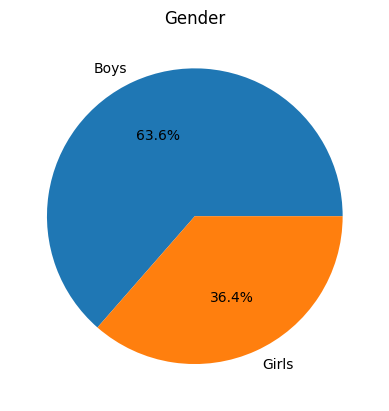

In [7]:
# Get value counts for gender
vc = train['Basic_Demos-Sex'].value_counts()

# Extract counts (assuming 'count' column doesn't exist)
counts = vc.values

# Create labels (assuming 'count' column doesn't exist)
labels = ['Boys', 'Girls']  # Assuming 'Male' maps to 'Boys' and 'Female' to 'Girls'

# Plot the pie chart
plt.pie(counts, labels=labels, autopct="%1.1f%%")  # Add percentages to pie slices
plt.title('Gender')
plt.show()


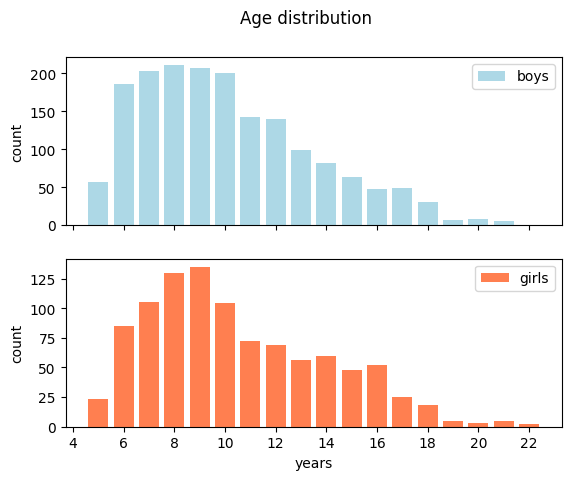

In [8]:
#'train' is DataFrame
_, axs = plt.subplots(2, 1, sharex=True)

for sex in range(2):
  ax = axs.ravel()[sex]

  # Filter by sex using boolean indexing
  sex_filter = train['Basic_Demos-Sex'] == sex
  vc = train[sex_filter]['Basic_Demos-Age'].value_counts()  # Access column after filtering

  # Plot the bar chart
  ax.bar(vc.index, vc.values, color=['lightblue', 'coral'][sex], label=['boys', 'girls'][sex])
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.set_ylabel('count')
  ax.legend()

plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

# <span style="background-color:#79a5ed;padding:15px;border-radius:40px;">⚖️Quadratic Weighted Kappa</span>

In [9]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = model_class
        
        for name, model in model_class.items():
            print("Name")
            print(name)
            model.fit(X_train, y_train)

        y_train_pred = blend_predict(X_train)#model.predict(X_train)
        y_val_pred = blend_predict(X_val)#model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = blend_predict(test_data)#model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    print(type(tpm))
    print(KappaOPtimizer.x)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission,model

# <span style="background-color:#79a5ed;padding:15px;border-radius:40px;">🖥️Pipelines and Models</span>

In [10]:
# Set a random seed for reproducibility
SEED = 40

# Define the number of cross-validation folds
K = 10

# Create a K-fold cross-validation object
kf = KFold(n_splits=K, shuffle=True, random_state=SEED)

# Create pipelines for  Catboost Regression, LightGBM Regression, and XGBoost Regression

# LightGBM Regression
lgbmr = LGBMRegressor(objective='regression', 
                      num_leaves=25, 
                      learning_rate=0.05, 
                      n_estimators=750, 
                      max_depth=7,
                      max_bin=200, 
                      bagging_fraction=0.75, 
                      bagging_freq=5, 
                      bagging_seed=SEED, 
                      feature_fraction=0.2, 
                      feature_fraction_seed=SEED, 
                      device='gpu',
                      verbose=0)

# XGBoost Regression
xgbr = XGBRegressor(learning_rate=0.01, 
                    n_estimators=500, 
                    max_depth=7, 
                    gamma=0.001, 
                    subsample=0.7, 
                    colsample_bytree=0.7, 
                    objective='reg:squarederror', 
                    nthread=-1, 
                    seed=SEED, 
                    reg_alpha=0.001,
                    reg_lambda=0.001,
                    tree_method='gpu_hist')

#Using LGBMRegressor
Params_lgb = {'learning_rate': 0.03884249148676395, 'max_depth': 12, 'num_leaves': 413, 'min_data_in_leaf': 14,
           'feature_fraction': 0.7987976913702801, 'bagging_fraction': 0.7602261703576205, 'bagging_freq': 2, 
           'lambda_l1': 4.735462555910575, 'lambda_l2': 4.735028557007343e-06} 

Light = lgb.LGBMRegressor(**Params_lgb,random_state=SEED, verbose=-1,n_estimators=200)


# Using XGBRegressor
Params_xgb = {
    'learning_rate': 0.03884249148676395,
    'max_depth': 12,
    'max_leaves': 413,  # replacing num_leaves
    'min_child_weight': 14,  # approximate substitute for min_data_in_leaf
    'colsample_bytree': 0.7987976913702801,  # replacing feature_fraction
    'subsample': 0.7602261703576205,  # replacing bagging_fraction
    'reg_alpha': 4.735462555910575,  # replacing lambda_l1
    'reg_lambda': 4.735028557007343e-06  # replacing lambda_l2
}


XGBoost = xgb.XGBRegressor(**Params_xgb, random_state=SEED, verbosity=0, n_estimators=200)


# Using CatBoostRegressor
# Params_cat = {
#     'learning_rate': 0.03884249148676395,
#     'max_depth': 12,
#     'min_child_samples': 14,  # Equivalent to min_data_in_leaf
#     'rsm': 0.7987976913702801,  # Equivalent to feature_fraction
#     'subsample': 0.7602261703576205,  # Equivalent to bagging_fraction
#     'l2_leaf_reg': 4.735462555910575,  # Equivalent to lambda_l2/lambda_l1
#     'random_seed': SEED,  # Use same seed for reproducibility
#     'n_estimators': 200,  # Number of trees
#     'verbose': 0  # Suppresses output
# }


# CatBoost = CatBoostRegressor(**Params_cat)

# StackingCVRegressor LGBM, XGB, CAT,
# stack = StackingCVRegressor(regressors=(Light,XGBoost, CatBoost, lgbmr), meta_regressor=xgbr, use_features_in_secondary=True)

# <span style="background-color:#79a5ed;padding:15px;border-radius:40px;">📕Create Dictionaries</span>

In [11]:
Params_lgb = {'learning_rate': 0.03884249148676395, 
              'max_depth': 12, 
              'num_leaves': 413, 
              'min_data_in_leaf': 14,
              'feature_fraction': 0.7987976913702801, 
              'bagging_fraction': 0.7602261703576205, 
              'bagging_freq': 2, 
              'lambda_l1': 4.735462555910575, 
              'lambda_l2': 4.735028557007343e-06
             } 

Light = lgb.LGBMRegressor(**Params_lgb,random_state=SEED, verbose=-1,n_estimators=200)
# Submission,model = TrainML(Light,test)


Params_xgb = {
    'learning_rate': 0.03884249148676395,
    'max_depth': 12,
    'max_leaves': 413,  # replacing num_leaves
    'min_child_weight': 14,  # approximate substitute for min_data_in_leaf
    'colsample_bytree': 0.7987976913702801,  # replacing feature_fraction
    'subsample': 0.7602261703576205,  # replacing bagging_fraction
    'reg_alpha': 4.735462555910575,  # replacing lambda_l1
    'reg_lambda': 4.735028557007343e-06  # replacing lambda_l2
}

# Using XGBRegressor
XGBoost = xgb.XGBRegressor(**Params_xgb, random_state=SEED, verbosity=0, n_estimators=200)

# Create a dictionary to store the models
models = {'LightGBMRegressor': lgbmr, 
          'XGBoostRegressor': xgbr, 
          'XGBoostRegressor2': XGBoost, 
          'LightGBMRegressor2': Light}

# Initialize dictionaries for predictions and scores
predictions = {}
scores = {}

def blend_predict(X):
    return ((0.2 * xgbr.predict(X)) +
            (0.4 * Light.predict(X)) +
            (0.2 * XGBoost.predict(X)) +
            (0.2 * lgbmr.predict(X)))

# <span style="background-color:#79a5ed;padding:15px;border-radius:40px;">🚅Train Model</span>

In [12]:
Submission, model = TrainML(models, test)

Training Folds: 100%|██████████| 5/5 [01:08<00:00, 13.78s/it]


Mean Train QWK --> 0.8871
Mean Validation QWK ---> 0.3803
----> || Optimized QWK SCORE ::  0.449
<class 'numpy.ndarray'>
[0.55541823 0.97143241 2.75093414]


# <span style="background-color:#79a5ed;padding:15px;border-radius:40px;">📁Submission</span>

In [13]:
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
0    12
1     5
2     3
Name: count, dtype: int64


In [14]:
Submission.head(20)

,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0
